In [1]:
# autoreload libaries
%load_ext autoreload
%autoreload 2

In [2]:
import data_load
import pandas as pd
import glob
import matplotlib.pyplot as plt 
import numpy as np
from datetime import datetime, timedelta


cdc_frames = data_load.get_cdc_dataframe ()
jhu_frames = data_load.get_jhu_dataframe ()
jhu_weekly_df = data_load.get_jhu_dataframe_weekly ()
baseline2_df = data_load.get_linear_baseline()

ensemble_eligibility_df = data_load.get_ensemble_eligibility_dataframe()


cdc_frames.loc[cdc_frames.Model == "COVIDhub-baseline", "Model"] = "Baseline I"

/opt/conda/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3347: DtypeWarning: Columns (0) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [3]:
def ensemble_forecast(cdc_frames, model_weights, forecast_date, horizon=4):
    numerator = 0
    denominator = 0
    
    for model in model_weights.keys():
        if not data_load.check_ensemble_eligiblity(ensemble_eligibility_df, model, forecast_date):
            continue
        pred = cdc_frames[(cdc_frames.Model == model) & (cdc_frames.forecast_date == forecast_date) & (cdc_frames.target == str(horizon) +" wk ahead inc case" )]
        pred_point = pred.point.values
        if len(pred_point)>0:
            pred_point = pred_point[0]
        else:
            continue
        numerator += pred_point*model_weights[model]
        denominator += model_weights[model]
    if denominator == 0:
        return None
    else:
        return round(numerator/denominator, 2)

In [16]:
def get_model_weights_for_forecast_date(cdc_frames, eligibility_frame, jhu_weekly_df, cur_forecast_date, earliest_forecast_date, last_forecast_date):
    model_weights = {}
    for model in cdc_frames.Model.unique():
        if model == "DDS-NBDS":
            continue
        
        if data_load.check_ensemble_eligiblity(eligibility_frame, model, cur_forecast_date):
            model_frame = data_load.get_model_by_date_range(model, cdc_frames, 4, start=earliest_forecast_date, end = last_forecast_date)
            mae, pred_count = data_load.get_mae(model_frame, jhu_weekly_df, earliest_forecast_date, last_forecast_date)
            if pred_count > 0:
                #model_weights[model] = 1/mae
                model_weights[model] = 1
    return model_weights

In [17]:
def get_ensemble_preds (cdc_frames, eligibility_frame, weight_function, lookback_weeks = None):
    forecasts = {}
    earliest_forecast_date = "2020-02-15"
    for forecast_date in cdc_frames.forecast_date.unique():
        
        if lookback_weeks is not None:
            earliest_forecast_date = data_load.add_days(forecast_date, -7*lookback_weeks)
        last_forecast_date = data_load.add_days(forecast_date, -7)

        cdc_period_frame = cdc_frames[(cdc_frames.target_end_date<=last_forecast_date) & (cdc_frames.target_end_date>=earliest_forecast_date)]
        
        pred_target_date = data_load.add_days(forecast_date, 7*4)
        
        model_weights = weight_function(cdc_frames, eligibility_frame, jhu_weekly_df, forecast_date, earliest_forecast_date, last_forecast_date)
        forecast = ensemble_forecast(cdc_frames, model_weights, forecast_date, horizon=4)
        
        if forecast is not None:
            forecasts[pred_target_date] = forecast 

    ensemble_pred_df = pd.DataFrame.from_dict(forecasts, orient='index', columns=['point'])
    ensemble_pred_df["target_end_date"]=pd.to_datetime(ensemble_pred_df.index)
    ensemble_pred_df = ensemble_pred_df.set_index("target_end_date", drop=True).sort_index(ascending=True)
    return ensemble_pred_df

In [18]:
ensemble_pred_df = get_ensemble_preds(cdc_frames,ensemble_eligibility_df,get_model_weights_for_forecast_date, lookback_weeks=None)

In [19]:
covidhub_df = data_load.get_model_by_date_range("COVIDhub-ensemble", cdc_frames, 4, start="2020-02-15", end = None)

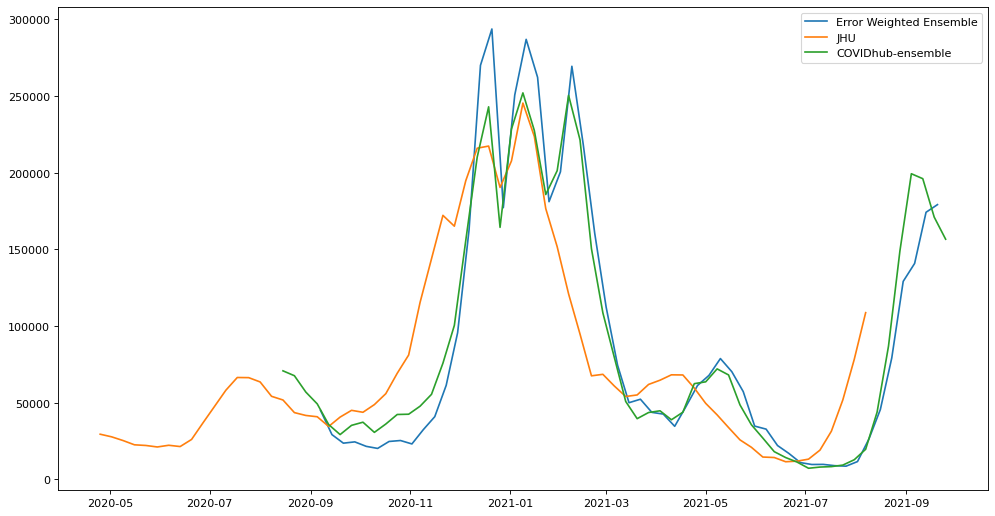

In [20]:
from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=80)

plt.plot(ensemble_pred_df["point"], label="Error Weighted Ensemble")
plt.plot(jhu_weekly_df["WeeklyCases"], label="JHU")
plt.plot(covidhub_df["point"], label="COVIDhub-ensemble")
plt.legend()
plt.show()

In [ ]:
from matplotlib.pyplot import figure
figure(figsize=(15, 8), dpi=80)

plt.plot(ensemble_pred_df["point"], label="Error Weighted Ensemble")
plt.plot(jhu_weekly_df["WeeklyCases"], label="JHU")
plt.plot(covidhub_df["point"], label="COVIDhub-ensemble")
plt.legend()
plt.show()

In [48]:
cdc_frames.Model.unique()

array(['BPagano-RtDriven', 'CEID-Walk', 'Baseline I', 'COVIDhub-ensemble',
       'CU-nochange', 'CU-scenario_high', 'CU-scenario_low',
       'CU-scenario_mid', 'CU-select', 'Columbia_UNC-SurvCon',
       'Covid19Sim-Simulator', 'CovidAnalytics-DELPHI',
       'FDANIHASU-Sweight', 'FRBSF_Wilson-Econometric',
       'Geneva-DetGrowth', 'IBF-TimeSeries', 'IEM_MED-CovidProject',
       'IUPUI-HkPrMobiDyR', 'IowaStateLW-STEM', 'JHUAPL-Bucky',
       'JHU_CSSE-DECOM', 'JHU_IDD-CovidSP',
       'KITmetricslab-select_ensemble', 'Karlen-pypm', 'LANL-GrowthRate',
       'LNQ-ens1', 'MIT_ISOLAT-Mixtures', 'MOBS-GLEAM_COVID',
       'Microsoft-DeepSTIA', 'OliverWyman-Navigator',
       'RobertWalraven-ESG', 'TTU-squider', 'UCF-AEM',
       'UChicagoCHATTOPADHYAY-UnIT', 'UMich-RidgeTfReg', 'USC-SI_kJalpha',
       'UVA-Ensemble', 'UpstateSU-GRU', 'COVIDhub-trained_ensemble',
       'MIT-Cassandra', 'MUNI-ARIMA', 'UCLA-SuEIR', 'USACE-ERDC_SEIR',
       'DDS-NBDS', 'IQVIA_ACOE-STAN', 'JCB-PRM', 'QJ

In [53]:
data_load.get_model_by_date_range("DDS-NBDS", cdc_frames, 4, start="2021-03-15", end = "2021-06-15")

,point
target_end_date,
2021-03-22,1.062508e+06
2021-03-29,1.183531e+06
2021-04-05,4.215374e+05
2021-04-12,1.342039e+07
2021-04-19,4.696121e+07
2021-04-26,2.168514e+06


In [55]:
data_load.get_model_by_date_range("COVIDhub-ensemble", cdc_frames, 4, start="2021-03-15", end = "2021-06-15")

,point
target_end_date,
2021-03-15,50821.714286
2021-03-22,39623.714286
2021-03-29,43635.714286
2021-04-05,44756.000000
2021-04-12,38909.571429
2021-04-19,43832.428571
2021-04-26,62449.571429
2021-05-03,63654.428571
2021-05-10,72085.857143


In [60]:
cdc_frames[cdc_frames.Model=="DDS-NBDS"][cdc_frames.target_end_date=="2021-04-19"]

<ipython-input-60-755b3bdc9721>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  cdc_frames[cdc_frames.Model=="DDS-NBDS"][cdc_frames.target_end_date=="2021-04-19"]


,Model,Team Name,forecast_date,target,target_end_date,location_name,State,fips,point,quantile_0.025,quantile_0.25,quantile_0.75,quantile_0.975
5560,DDS-NBDS,Discrete Dynamical Systems,2021-03-29,3 wk ahead inc case,2021-04-19,National,National,US,2.632914e+06,248882.0,872625.0,4205763.0,37357154.0
5971,DDS-NBDS,Discrete Dynamical Systems,2021-03-22,4 wk ahead inc case,2021-04-19,National,National,US,4.696121e+07,146924.0,313856.0,2430604.0,328728465.0
